In [25]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
from tensorflow import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check if GPU is running

In [6]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Debug to make sure dataset is ready for training

In [ ]:
!retinanet-debug --config config/config.ini --no-gui --output-dir ../Playground/ csv annotations.csv classes.csv 

## Inference on pre-trained model

In [7]:
def load_model(model_path): 
    return models.load_model(model_path, backbone_name='resnet50')

In [12]:
# loading the model
model = load_model('../keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [22]:
def run_detection(model, filepath, labels_file="classes.csv"):
  
    labels = [i.split(",") for i in open(labels_file).read().split("\n")]
    labels_to_names = dict([(int(str_id), name) for name, str_id in labels])
    
    image = read_image_bgr(filepath) 

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        print(box, score, label)
        if (label == 0 and score < .3) or score < .5: 
            break
        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()



processing time:  0.19648075103759766
[-4.60875 -4.60875 -4.60875 -4.60875] -1.0 -1


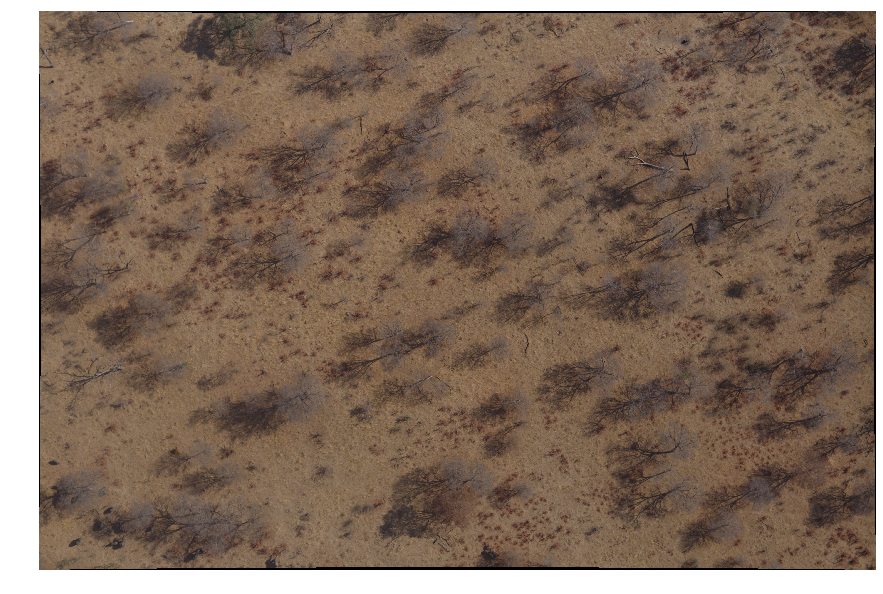

In [23]:
# running the model

run_detection(model, "../data/training_images/026ae7f5cddac223d6e364b7c16779b271cb3198.jpg")

The pre-trained model does not pick up any elephants. But we will use the same weights for training